In [1]:
import importlib
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-02-04 10:02:19 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-02-04 10:02:19 INFO: Use device: gpu
2021-02-04 10:02:19 INFO: Loading: tokenize
2021-02-04 10:02:21 INFO: Loading: pos
2021-02-04 10:02:22 INFO: Loading: lemma
2021-02-04 10:02:22 INFO: Loading: depparse
2021-02-04 10:02:24 INFO: Loading: sentiment
2021-02-04 10:02:25 INFO: Loading: ner
2021-02-04 10:02:26 INFO: Done loading processors!


In [2]:
sentence = "a women is dancing in a cage"
pipeline = PolarizationPipeline(verbose=0, parser="stanford")
annotation = pipeline.single_polarization(sentence)
ann = list(annotation['annotated'].popkeys())
print(list(zip(*ann)))
#print(annotation['word_dict'])
#print(annotation['polarized_tree'].sorted_leaves())

[('a', 'women', 'is', 'dancing', 'in', 'cage'), ('DT', 'NNS', 'VBZ', 'VBG', 'IN', 'NN'), ('+', '+', '+', '+', '+', '+'), (1, 2, 3, 4, 5, 7)]


In [3]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

OPENIE_MODEL = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz"
ie_extractor = Predictor.from_path(OPENIE_MODEL)

error loading _jsonnet (this is expected on Windows), treating C:\Users\ZEMING~1\AppData\Local\Temp\tmpnlslrj2t\config.json as plain json


In [4]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [17]:
from pattern.en import pluralize, singularize
from copy import copy

def fix_info(desc):
    out = desc.replace("ARG0: ", "")
    out = out.replace("ARG1: ", "")
    out = out.replace("V: ", "")
    out = out.replace("[", "")
    out = out.replace("]", ",")
    out = out.split(",")
    out = list(map(lambda x: x.strip(), out))
    return out

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.tree_log = []
        self.sent_log = []
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', 
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            "appos", 'compound', 'compound:ptr']
        self.mod_at_right = []
        self.mod_symmetric = ["conj"]
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.original = original  
        self.annotated = annotated
        self.ie_pred = {}
        verbs = ie_extractor.predict(original)['verbs']
        for verb in verbs:
            self.ie_pred[verb['verb']] = fix_info(verb['description'])        
        self.generate(self.deptree)

    def generate(self, tree):
        if tree.val in self.mod_at_left:
            self.left_modifier_generate(tree)
        elif tree.val in self.mod_symmetric:
            self.symmetric_generate(tree)
        elif tree.is_tree:
            self.generate_default(tree)

    def delete_modifier(self, tree, modifier):
        if modifier.val == "cc":
            self.delete_modifier(modifier, modifier.right)
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right


    def delete_left_modifier(self, tree):
        self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if left.mark == "+" or left.mark == "=":
            self.delete_right_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)   
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if right.mark == "+" or right.mark == "=":
            self.delete_left_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)   
        
        self.generate(tree.left)
        self.generate(tree.right)

    def rollback_annotation(self, generated, original):
        word_id = self.annotated[generated]
        del self.annotated[generated]
        self.annotated[original] = word_id

    def add_modifier(self, tree, mod, head, direct=0):
        if direct == 0:
            generated = ' '. join([mod, head])
        else:
            generated = ' '. join([head, mod])

        orig_key = (head, tree.pos, tree.mark)
        gen_key = (generated, tree.pos, tree.mark)

        word_id = self.annotated[orig_key]
        del self.annotated[orig_key]
        self.annotated[gen_key] = word_id
        self.save_tree(isTree=False)
        self.rollback_annotation(gen_key, orig_key)

    def generate_default(self, tree):
        left = tree.left
        right = tree.right

        if right.pos is not None:
            if "NN" in right.pos and right.mark == "-":
                for adj in self.kb["ADJ"]:
                    self.add_modifier(right, adj, right.val)
                for rel in self.kb["RCL"]:
                    self.add_modifier(right, rel, right.val, 1)
            elif "VB" in right.pos and right.mark == "-":
                for adv in self.kb["ADV"]:
                    self.add_modifier(right, adv, right.val)
                    self.add_modifier(right, adv, right.val, 1)
                    description = self.ie_pred[right.val]
                    arg1 = description[2]
                    self.sent_log.append(
                        self.original.replace(
                            arg1, ' '.join([arg1, adv])))

        self.generate(tree.left)
        self.generate(tree.right)  

    def save_tree(self, isTree):
        if isTree:
            leaves = self.deptree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            self.tree_log.append(self.deptree.copy())
            #leaves = copy(self.deptree).sorted_leaves().popkeys()
            #sentence = ' '.join([x[0] for x in leaves])
        else:
            annotated_cp = deepcopy(self.annotated)
            self.sent_log.append(
                ' '.join([word[0] for word in list(annotated_cp.popkeys())]))

    def buildTree(self, config):
        left = BinaryDependencyTree(
            config['mod'], "N", "N", 1024, 
            wid=config['lid'], pos="JJ")
        right = BinaryDependencyTree(
            config['head'], "N", "N", 1024,
            wid=config['rid'], pos="NN")
        tree = BinaryDependencyTree(config['rel'], left, right, 1025)
        left.mark = config['mark']
        right.mark = config['mark']
        tree.mark = config['mark']
        return tree

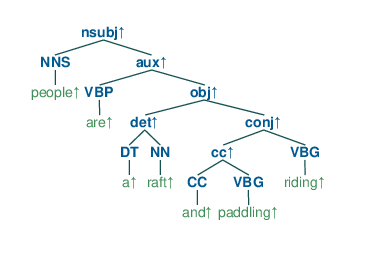

In [18]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

upward = ["Some students sing to celebrate their graduation",
          "An Irishman won the nobel prize for literature.",
          "A big poison spider was spanning a web", 
          "A Californian special policeman pulled a car over and spole to the driver",
          "A woman is dancing in a cage", 
          "A woman is dancing beautifully in a cage", 
          "People are riding and paddling a raft"]

downward = ["No spider was spanning a web"]

hypothesis = ["No poison spider was spanning a web"]

kb = {"ADJ": ["beautiful", "red", "fragret"], 
      "ADV": ["ergently", "clearly", "neccesaraly"],
      "RCL": ["which is beautiful", "which opens at night"]}

annotations = []
pipeline = PolarizationPipeline(verbose=0, parser="stanford")
for sentence in ['People are riding and paddling a raft']:
    annotation = pipeline.single_polarization(sentence)
    annotations.append(annotation)

with open("./generation_log.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    for annotation in annotations:
        generate_log.write("\n====================================")
        annotation_info = pipeline.get_annotation_info(annotation['annotated'])
        generate_log.write("\nInit Premise: " + annotation['original'])
        
        polarized = pipeline.postprocess(annotation['polarized_tree'], {})
        btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
        jupyter_draw_nltk_tree(btreeViz) 
        phrasalGenerator.kb = kb
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], annotation['annotated'], annotation['original'])
        for gen_tree in phrasalGenerator.tree_log:
            leaves = gen_tree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            generate_log.write("\nNext Premise: " + sentence)
        for gen_sent in phrasalGenerator.sent_log:
            generate_log.write("\nNext Premise: " + ' '.join(gen_sent.popkeys()))
    